# Tonnetz Diffusion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

sns.set_context('talk')

import numpy as np
import statsmodels.api as sm
from scipy.stats import entropy

In [2]:
intervals = ['+P5', '-P5', '+m3', '-m3', '+M3', '-M3']

In [3]:
def plot_parameters(df, c_range, labels=None):
    
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        sc = sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.3}, 
            line_kws={'color':'k'},
            marker='+',
            lowess=True,
            ax=ax
        )
        ax.set_ylabel(l)
        ax.set_xlabel('')
        ax.set_ylim(0,1)
    plt.tight_layout()
    return fig

In [4]:
def bootstrap_lowess(df, c_range, labels=None, B=100, scatter=True, colors=None):
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        if scatter:
            sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.2}, 
            marker='+',
            fit_reg=False,
            ax=ax
        )
        
        for b in range(B):
            b_sample = df[[str(i), 'year']].sample(df.shape[0], replace=True)

            x = b_sample.year.values
            y = b_sample[str(i)].values
            lowess = sm.nonparametric.lowess(y, x, frac=0.3)

            ax.plot(lowess[:, 0], lowess[:, 1], alpha=.05, c=colors[i%6]['color'])
        ax.set_ylabel(l)

    plt.tight_layout()
    return fig

In [222]:
cols = ['JSDs'] + [str(i) for i in range(12)] + ['file'] + ['composer'] + ['year']
df = pd.read_csv('results.tsv', sep='\t', names=cols, header=0).sort_values(by='year')
df.head()

JSDs         0         1             2             3             4  \
1444  0.084306  0.546899  0.453101  1.145053e-16  0.000000e+00  3.797418e-17   
1442  0.082131  0.340914  0.632240  7.403419e-19  3.151637e-03  2.369442e-02   
1443  0.062455  0.669057  0.241962  3.861786e-02  9.336871e-13  1.611529e-13   
1445  0.042667  0.561634  0.438366  4.000629e-17  8.746670e-17  1.521919e-16   
1400  0.045719  0.526563  0.473437  1.429368e-16  1.485737e-16  9.523765e-18   

                 5         6         7             8         9        10  \
1444  0.000000e+00  0.825137  0.881071  4.187719e-01  0.559761  0.378611   
1442  8.765961e-17  0.733203  0.893502  6.852771e-01  0.129920  0.067856   
1443  5.036231e-02  0.981455  0.423207  5.527872e-13  0.666220  0.619354   
1445  7.014793e-17  0.893876  0.771316  3.005533e-01  0.617021  0.441614   
1400  1.660025e-17  0.886907  0.791428  4.347314e-01  0.485341  0.239210   

                11                                               file  \
1444  1.122226e-01  ..\ExtendedTonality\data\DataFrames\Lugentium-...   
1442  6.137037e-01  ..\ExtendedTonality\data\DataFrames\Virtutibus...   
1443  7.413898e-13  ..\ExtendedTonality\data\DataFrames\Gratissima...   
1445  8.065462e-02  ..\ExtendedTonality\data\DataFrames\Rex-quem-m...   
1400  1.251366e-01  ..\ExtendedTonality\data\DataFrames\Messe-de-N...   

     composer    year  
1444    Vitry  1361.0  
1442    Vitry  1361.0  
1443    Vitry  1361.0  
1445    Vitry  1361.0  
1400  Machaut  1370.0

In [223]:
df['tonal_center'] = df['file'].apply(lambda x: pd.read_csv(x, engine='python').tpc.value_counts().idxmax())

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


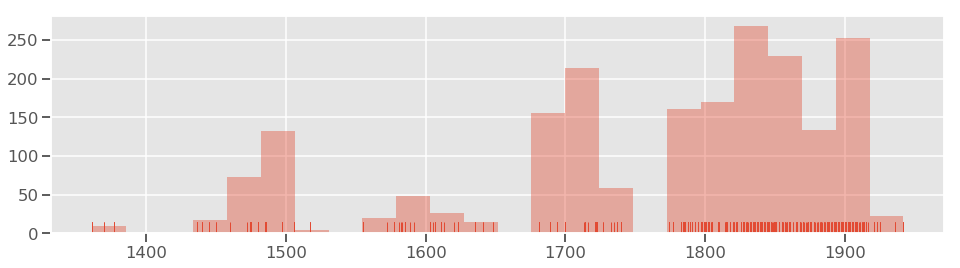

In [6]:
fig, ax = plt.subplots(figsize=(16,4))
sns.distplot(df.year.dropna(), rug=True, kde=False,norm_hist=False)
plt.xlabel('')
plt.savefig("img/corpus.png", dpi=300);

## Interval weights

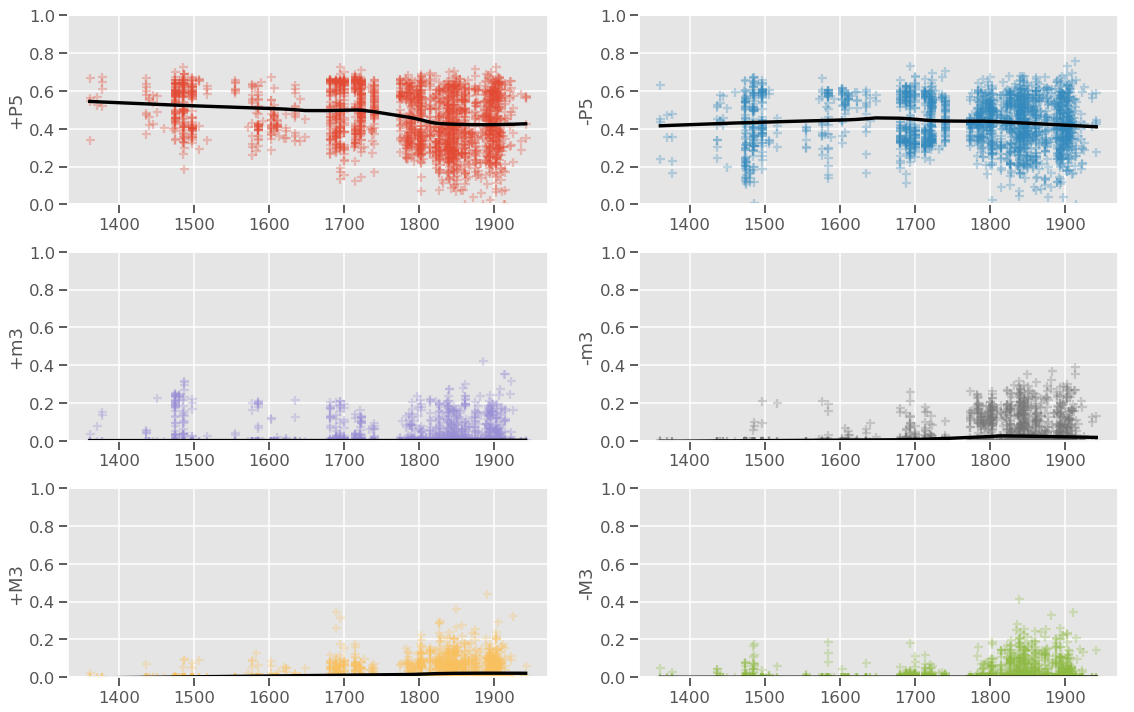

In [7]:
fig = plot_parameters(df, [0,5], labels=intervals)
plt.savefig('img/interval_weights.png', dpi=300)

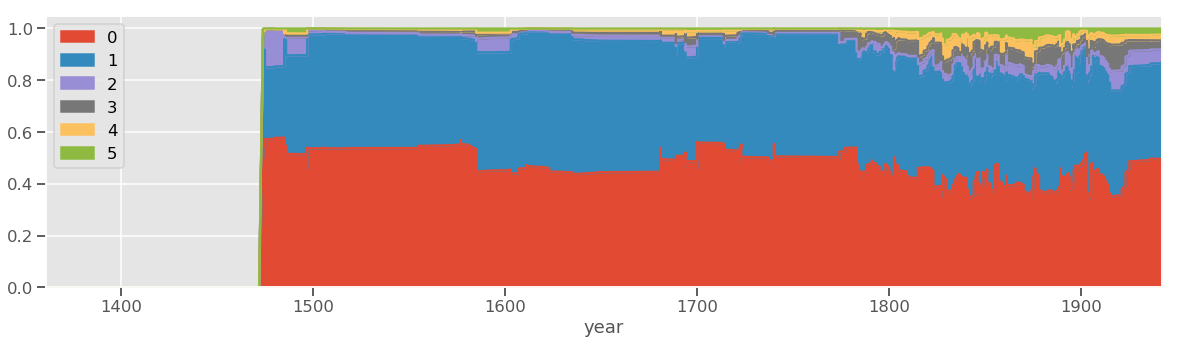

In [40]:
stacked = df.loc[:,[str(i) for i in range(6)]].rolling(window=30, win_type='cosine', center=False).mean()
stacked.index = df.year
stacked.plot(kind='area', figsize=(20,5))

plt.margins(0,0);

In [9]:
catcolors = list(plt.rcParams['axes.prop_cycle'])

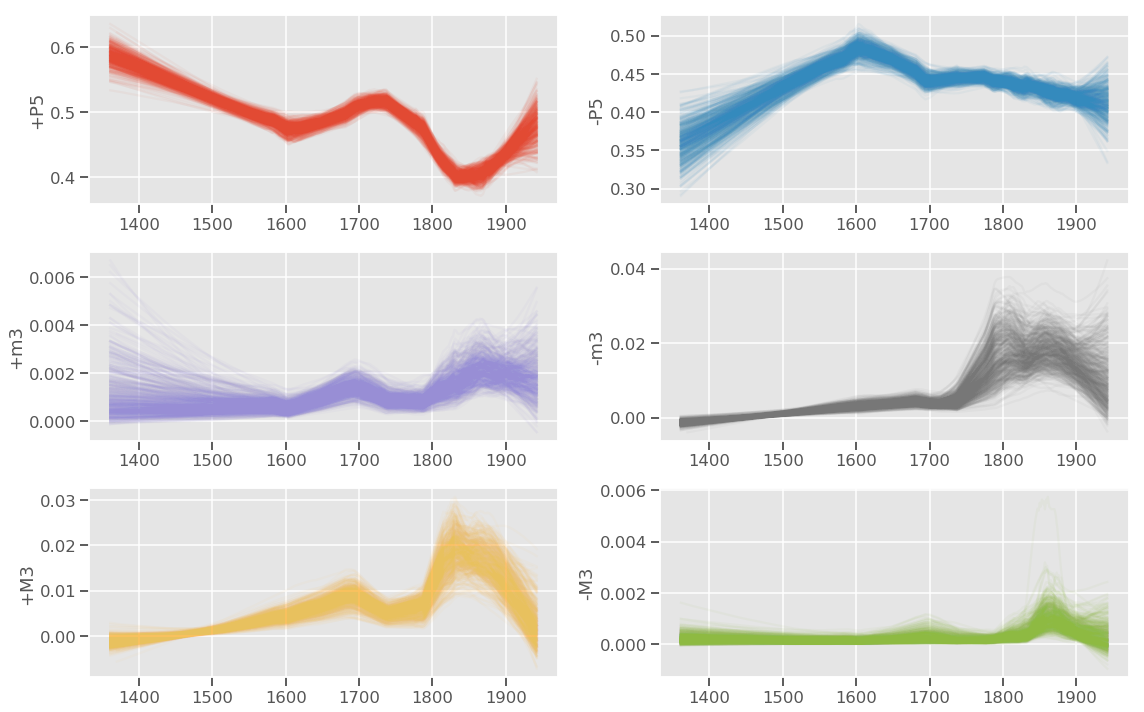

In [10]:
fig = bootstrap_lowess(df, [0,5], scatter=False, B=500, labels=intervals, colors=catcolors)
plt.savefig('img/bootstrapped_weights.png', dpi=300)

Observations:
* It seems that there are strong correlations between +m3 and -M3 (major triad), and between -m3 and +M3 (minor triad). Viewed absolutely, the major triad components are stronger (because minor is a mixed mode?)
* If also taking the fifths into account: how do dualistic theories play out?
* +P5 and -P5 are almost inverse patterns "W" and "M" (slightly shifted in time towards the end)

## Interval decays

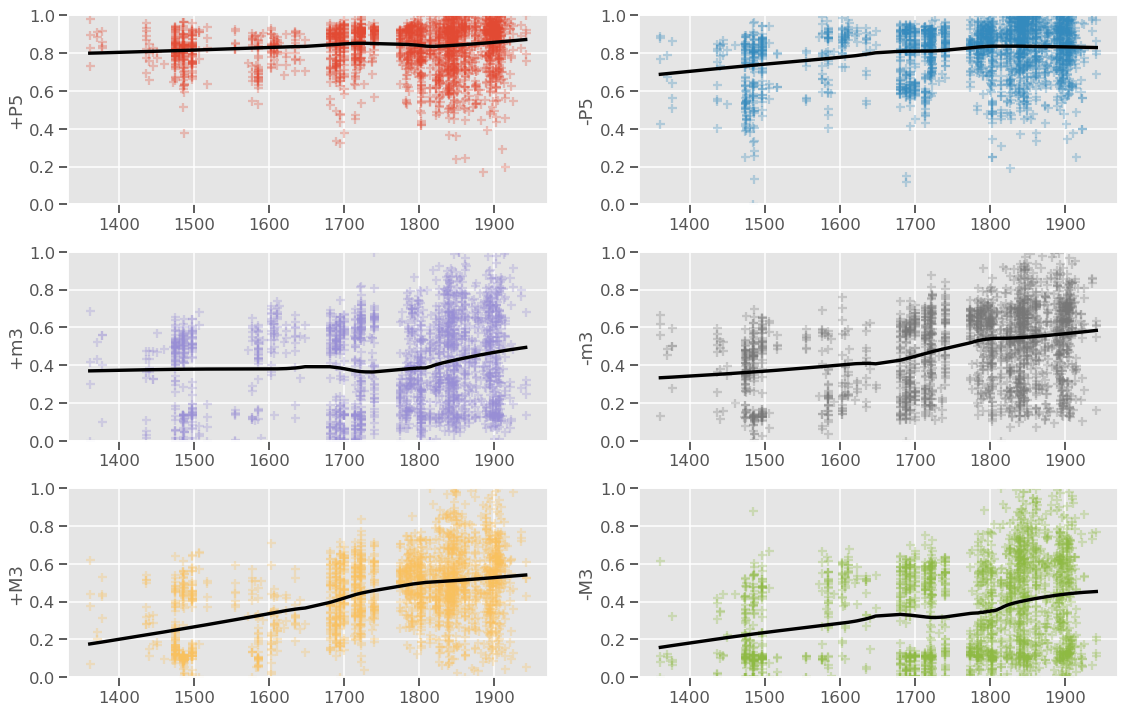

In [11]:
fig = plot_parameters(df, [6,12], labels=intervals)
plt.savefig('img/interval_params.png', dpi=300)

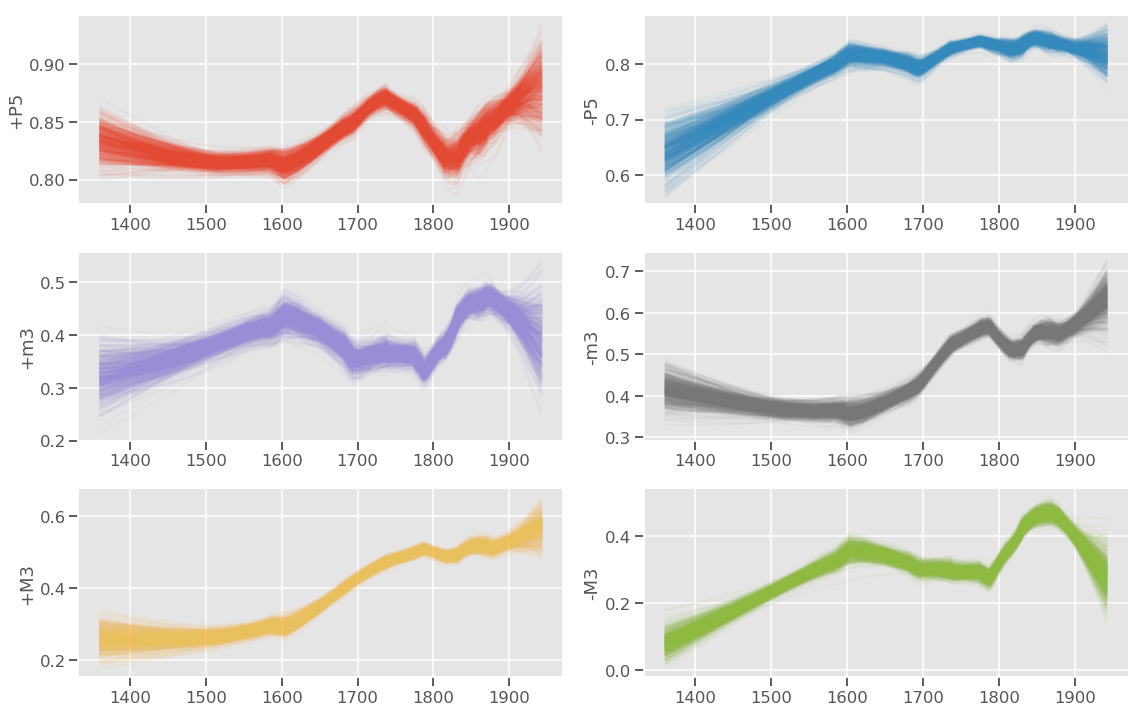

In [12]:
fig = bootstrap_lowess(df, [6,12], scatter=False, B=500, labels=intervals, colors=catcolors)
plt.savefig('img/bootstrapped_params.png', dpi=300)

## Divergences from true distributions per composer

In [224]:
df['sqrtJSDs'] = df['JSDs'].apply(np.sqrt)

In [14]:
df.sqrtJSDs.max()

0.40003025747721704

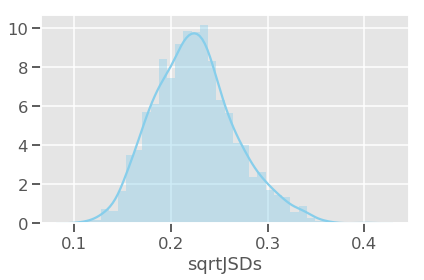

In [15]:
sns.distplot(df.sqrtJSDs, color='skyblue')
plt.tight_layout()
# plt.savefig('img/JSDs_dist.png', dpi=300);

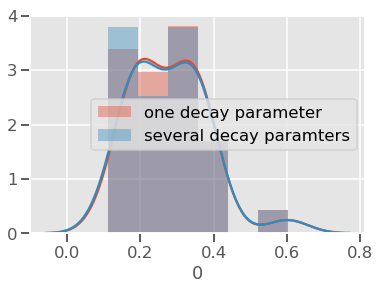

In [16]:
df1 = pd.read_csv('results_1.tsv', sep='\t')
df6 = pd.read_csv('results_6.tsv', sep='\t')
sns.distplot(df1.iloc[:,0].apply(np.sqrt), label='one decay parameter')
sns.distplot(df6.iloc[:,0].apply(np.sqrt), label='several decay paramters')
plt.legend();

It doesn't seem to make a difference whether there is one global decay parameter (per piece) or one for each interval.

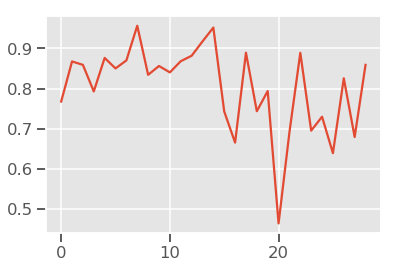

In [17]:
df1.iloc[:,7].plot();

The global parameter values are largely determined by the fifths (+/-P5). Since the third components (+/-m3, +/-M3) are relatively weak they don't fall into the weight.

What would be an objective measure to show that it is better to include decay parameters for all intervals separately? The $d_JS$ values are not sufficiently different. It _should_ be the case that if the global decay parameter is high (around .8) that the third components are much weaker because everything is already covered by the fifths.

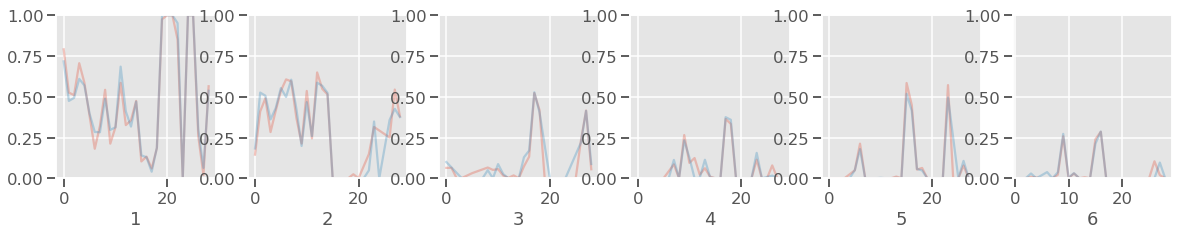

In [18]:
fig,axes = plt.subplots(1,6, figsize=(20,3))
for i in range(1,7):
    df1.iloc[:,i][df1.iloc[:,i]>0].plot(ax=axes[i-1], alpha=.3)
    df6.iloc[:,i][df6.iloc[:,i]>0].plot(ax=axes[i-1], alpha=.3)
    axes[i-1].set_xlabel(i)
    axes[i-1].set_ylim(0,1)
plt.show()

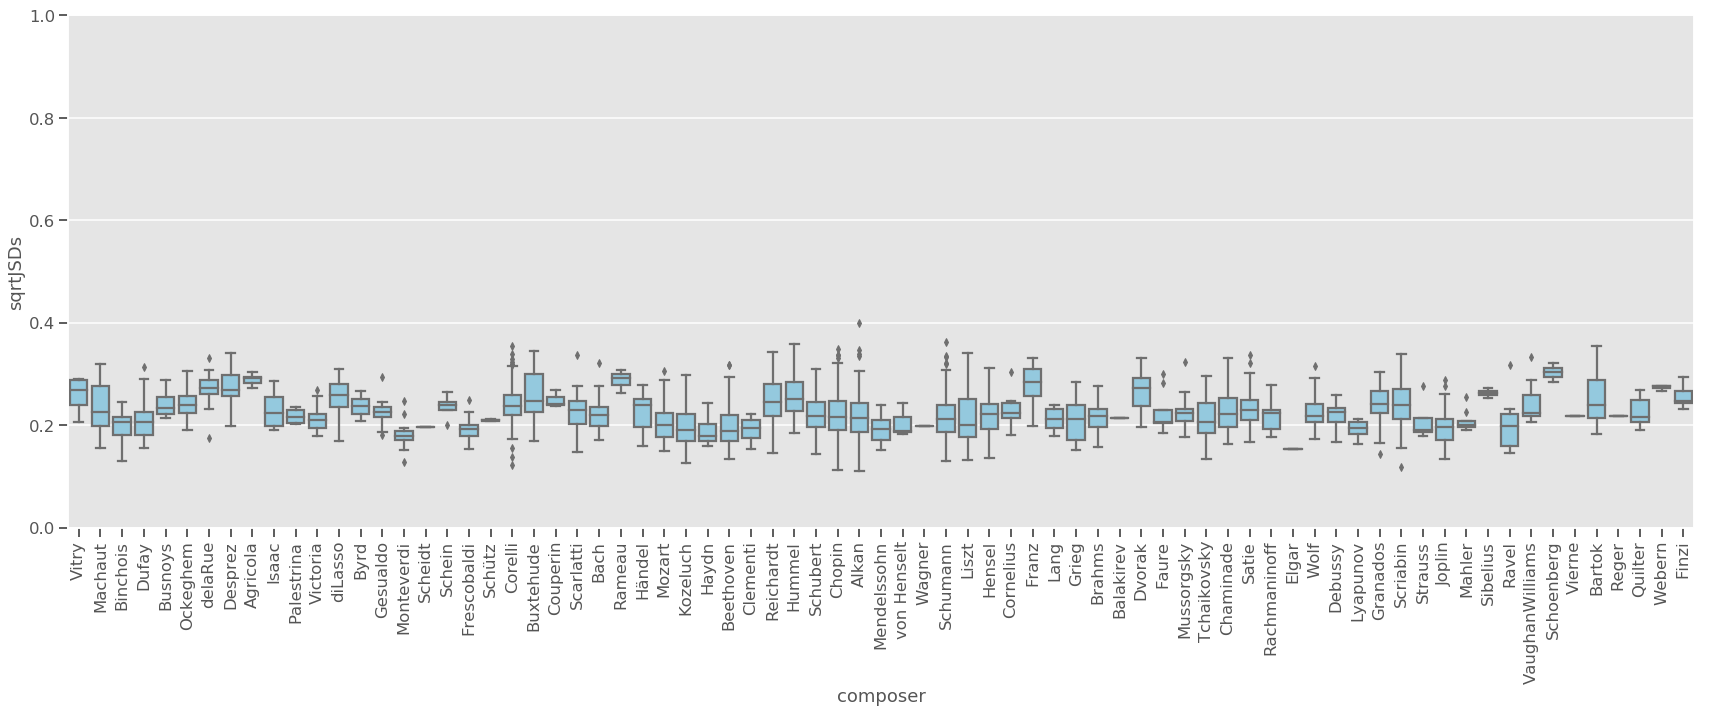

In [19]:
fig, ax = plt.subplots(figsize=(24,10))

sns.boxplot(
    x="composer", 
    y="sqrtJSDs",
    color='skyblue',
    data=df, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
plt.ylim(0,1)
# plt.savefig('img/JSDs_composers.png', dpi=300)
plt.show()

In [20]:
best = df.loc[df.sqrtJSDs.idxmin()]
best

JSDs                                                0.0122572
0                                                    0.291518
1                                                    0.450456
2                                                   0.0838312
3                                                    0.126512
4                                                   0.0274615
5                                                   0.0202213
6                                                     0.80718
7                                                    0.937718
8                                                    0.655795
9                                                    0.649903
10                                                    0.52406
11                                                   0.599993
file        ..\ExtendedTonality\data\DataFrames\Scherzo_Fo...
composer                                                Alkan
year                                                     1847
sqrtJSDs

In [21]:
worst = df.loc[df.sqrtJSDs.idxmax()]
worst

JSDs                                                 0.160024
0                                                    0.391691
1                                                    0.168153
2                                                    0.274584
3                                                 3.46159e-19
4                                                   0.0818809
5                                                    0.083691
6                                                    0.756891
7                                                    0.496177
8                                                    0.836205
9                                                    0.188351
10                                                  0.0740605
11                                                   0.736131
file        ..\ExtendedTonality\data\DataFrames\Un_Morceau...
composer                                                Alkan
year                                                     1840
sqrtJSDs

### Symmetry (dualistic perspective)
#### Parameter weights

In [22]:
ints = df[[str(i) for i in range(6)]].copy()
ints = ints.melt()
ints.variable = ints.variable.astype(int)
ints['direction'] = np.where(ints['variable'].apply(pd.to_numeric) % 2 == 0, 'acending', 'descending')
ints['interval'] = ['P5' if s in (0,1) else 'm3' if s in (2,3) else 'M3' if s in (4,5) else '' for s in ints.variable.values]
ints.head()

variable     value direction interval
0         0  0.546899  acending       P5
1         0  0.340914  acending       P5
2         0  0.669057  acending       P5
3         0  0.561634  acending       P5
4         0  0.526563  acending       P5

How does the symmetry change over time? Could the 19th century theorists have been "mislead" by contemporary music?

#### Parameter decays

In [23]:
dec = df[[str(i) for i in range(6,12)]].copy()
dec = dec.melt()
dec.variable = dec.variable.astype(int)
dec['direction'] = np.where(dec['variable'].apply(pd.to_numeric) % 2 == 0, 'acending', 'descending')
dec['interval'] = ['P5' if s in (6,7) else 'm3' if s in (8,9) else 'M3' if s in (10,11) else '' for s in dec.variable.values]
dec.head()

variable     value direction interval
0         6  0.825137  acending       P5
1         6  0.733203  acending       P5
2         6  0.981455  acending       P5
3         6  0.893876  acending       P5
4         6  0.886907  acending       P5

#### Plot

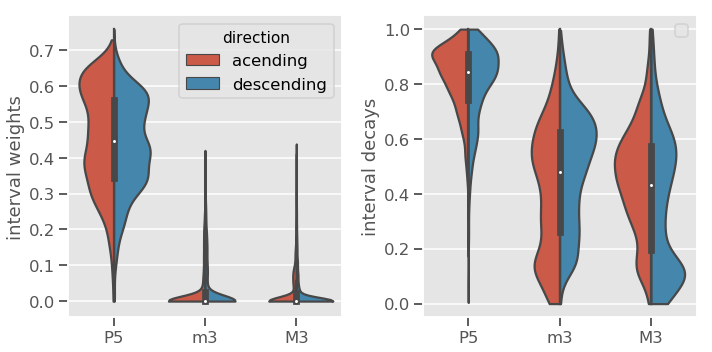

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.violinplot(
    data=ints, 
    x='interval', 
    y='value', 
    hue='direction', 
    split=True,
    cut=0,
    ax=axes[0],
)
axes[0].set_ylabel('interval weights')
axes[0].set_xlabel('')

sns.violinplot(
    data=dec, 
    x='interval', 
    y='value', 
    hue='direction', 
    split=True,
    cut=0,
    ax=axes[1]
)
axes[1].set_ylabel('interval decays')
axes[1].set_xlabel('')
axes[1].legend('')

plt.tight_layout()
plt.savefig('img/parameter_dists.png', dpi=300);

### Parameter Clustering

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [237]:
for i in [0,2,4]:
    df[str(i)+"-"+str(i+1)] = df[str(i)] + df[str(i+1)]

In [238]:
ints_df = df.iloc[:,-3:]

In [252]:
X_ = df.loc[:,[str(i) for i in range(0,12)]]

n = 12
pca = PCA(n_components=n)
Y_ = pca.fit_transform(X_)

In [253]:
[pca.explained_variance_ratio_[i] for i in range(n)]

[0.5042636075585263,
 0.20723397048785439,
 0.13643729472536573,
 0.06009614140255946,
 0.0477538996454425,
 0.018014829740516932,
 0.007763256209983059,
 0.007089190453034579,
 0.005576415431407041,
 0.0038314428824063477,
 0.0019399511880091574,
 2.7489468027656503e-10]

In [254]:
df['PC1'] = Y_[:,0]
df['PC2'] = Y_[:,1]

In [255]:
pca_composers = df.groupby('composer')[['PC1', 'PC2']].median()

In [256]:
df.head()

JSDs         0         1             2             3             4  \
1444  0.084306  0.546899  0.453101  1.145053e-16  0.000000e+00  3.797418e-17   
1442  0.082131  0.340914  0.632240  7.403419e-19  3.151637e-03  2.369442e-02   
1443  0.062455  0.669057  0.241962  3.861786e-02  9.336871e-13  1.611529e-13   
1445  0.042667  0.561634  0.438366  4.000629e-17  8.746670e-17  1.521919e-16   
1400  0.045719  0.526563  0.473437  1.429368e-16  1.485737e-16  9.523765e-18   

                 5         6         7             8      ...       \
1444  0.000000e+00  0.825137  0.881071  4.187719e-01      ...        
1442  8.765961e-17  0.733203  0.893502  6.852771e-01      ...        
1443  5.036231e-02  0.981455  0.423207  5.527872e-13      ...        
1445  7.014793e-17  0.893876  0.771316  3.005533e-01      ...        
1400  1.660025e-17  0.886907  0.791428  4.347314e-01      ...        

                                                   file  composer    year  \
1444  ..\ExtendedTonality\data\DataFrames\Lugentium-...     Vitry  1361.0   
1442  ..\ExtendedTonality\data\DataFrames\Virtutibus...     Vitry  1361.0   
1443  ..\ExtendedTonality\data\DataFrames\Gratissima...     Vitry  1361.0   
1445  ..\ExtendedTonality\data\DataFrames\Rex-quem-m...     Vitry  1361.0   
1400  ..\ExtendedTonality\data\DataFrames\Messe-de-N...   Machaut  1370.0   

     tonal_center  sqrtJSDs       PC1       PC2       0-1           2-3  \
1444            G  0.290355 -0.140263 -0.066511  1.000000  1.145053e-16   
1442            A  0.286585  0.631592 -0.281293  0.973154  3.151637e-03   
1443            F  0.249911 -0.720867 -0.117838  0.911020  3.861786e-02   
1445            G  0.206560 -0.297666 -0.052894  1.000000  1.274730e-16   
1400            D  0.213821 -0.076152 -0.206845  1.000000  2.915106e-16   

               4-5  
1444  3.797418e-17  
1442  2.369442e-02  
1443  5.036231e-02  
1445  2.223399e-16  
1400  2.612402e-17  

[5 rows x 23 columns]

In [257]:
pca.components_, pca.mean_

(array([[-2.39727735e-01,  1.80334942e-01,  2.89867879e-02,
         -1.49725943e-02,  3.39695332e-02,  1.14112909e-02,
         -1.02972661e-01,  2.11565168e-01,  5.51257947e-01,
         -3.28097563e-01, -2.86552988e-01,  5.98875800e-01],
        [-1.62291393e-01,  6.28015002e-02, -5.34229077e-02,
          1.05508732e-01,  2.79340479e-02,  1.94704617e-02,
          9.29344311e-02,  3.05649530e-01,  1.64501247e-01,
          6.06667997e-01,  6.06791971e-01,  2.98680946e-01],
        [-4.45556136e-01,  4.37003552e-01, -1.78362528e-01,
          1.93759592e-01,  5.21118637e-02, -5.89517988e-02,
         -4.83251876e-01,  3.14331138e-01, -4.01251666e-01,
          3.44891717e-03, -1.08154899e-01, -1.72950790e-01],
        [-3.81616844e-01, -4.38961391e-01,  1.88562909e-01,
          1.93138947e-01,  2.42164646e-01,  1.96723912e-01,
         -3.83352890e-01, -4.77216245e-01, -1.08653547e-01,
         -9.19224757e-02,  2.22778680e-01,  2.16560354e-01],
        [ 1.40873293e-01,  1.2343498

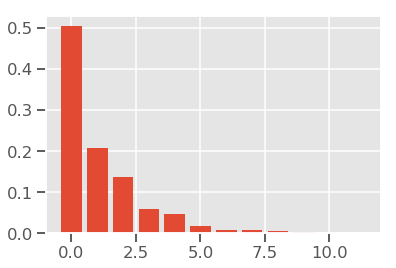

In [258]:
plt.bar(np.arange(n),pca.explained_variance_ratio_);

<BarContainer object of 12 artists>

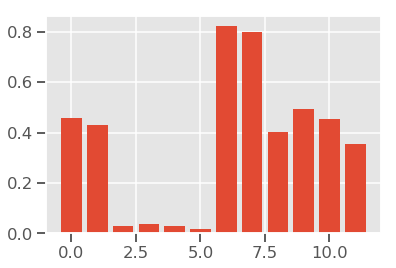

In [259]:
plt.bar(np.arange(n),pca.mean_)

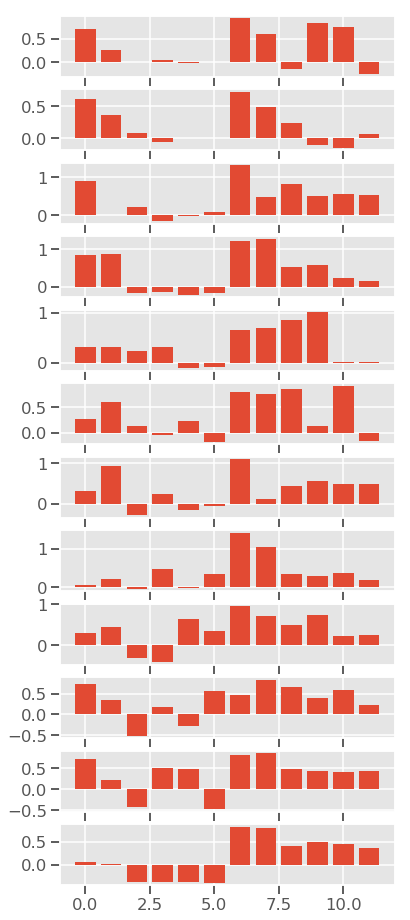

In [260]:
fig, axes = plt.subplots(n,1, figsize=(6,16))
for v, ax in zip(pca.components_, axes):
#     ax.bar(np.arange(12),v, alpha=.5)
    ax.bar(np.arange(n),pca.mean_-v)

---> use the principle components and plot the diffusion model for these settings

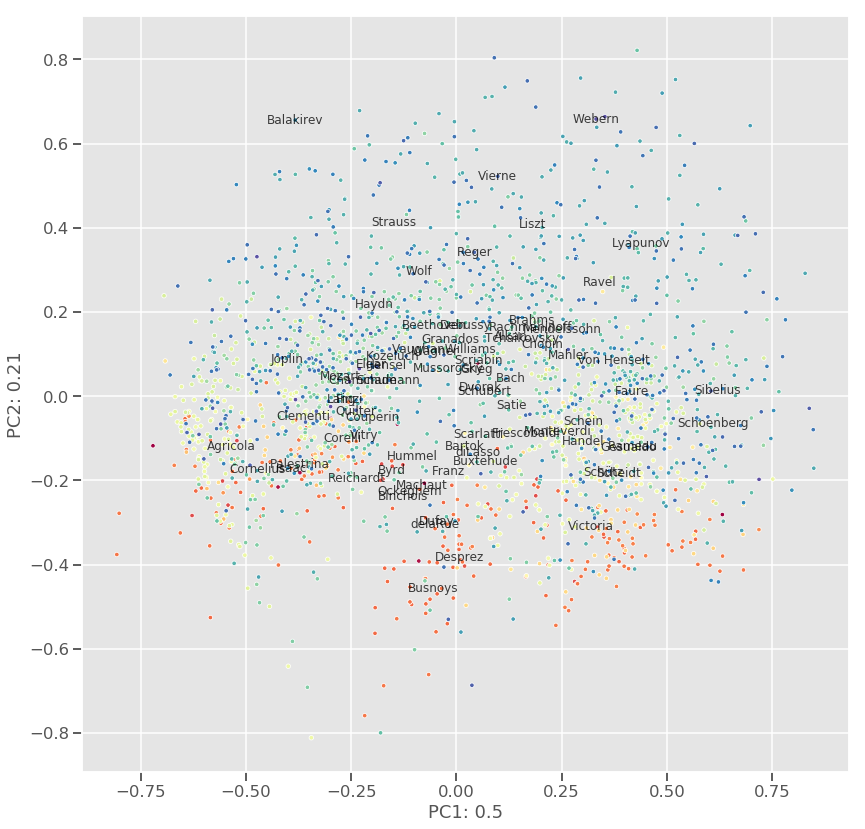

In [262]:
fig, ax = plt.subplots(figsize=(12,12))

ax.set_aspect('equal')
sns.scatterplot(Y_[:,0], Y_[:,1], alpha=1, marker='.', hue=df['year'], palette='Spectral', ax=ax)

for c, (x,y) in pca_composers.iterrows():
    ax.text(x,y,c, alpha=.75, va='center', ha='center', fontsize=12)
    
ax.set_xlabel("PC1: " + str(round(pca.explained_variance_ratio_[0],2)))
ax.set_ylabel("PC2: " + str(round(pca.explained_variance_ratio_[1],2)))
    
ax.get_legend().remove()
plt.tight_layout()
plt.savefig("img/TDM_PCA.png", dpi=600);

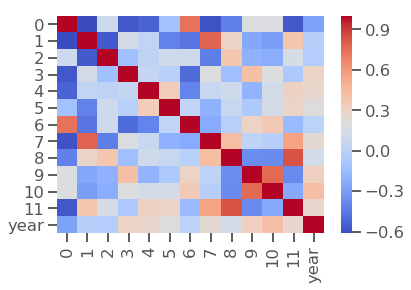

In [197]:
sns.heatmap(df[[str(i) for i in range(12)]+['year']].corr(), cmap='coolwarm')

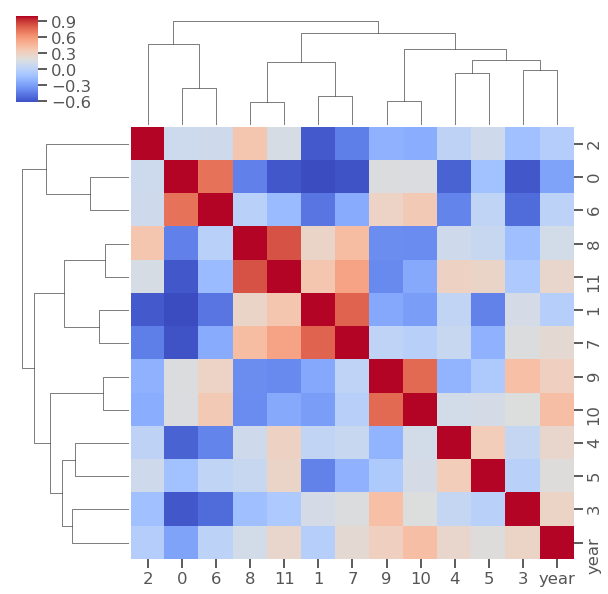

In [198]:
sns.clustermap(df[[str(i) for i in range(12)]+['year']].corr(), cmap='coolwarm')

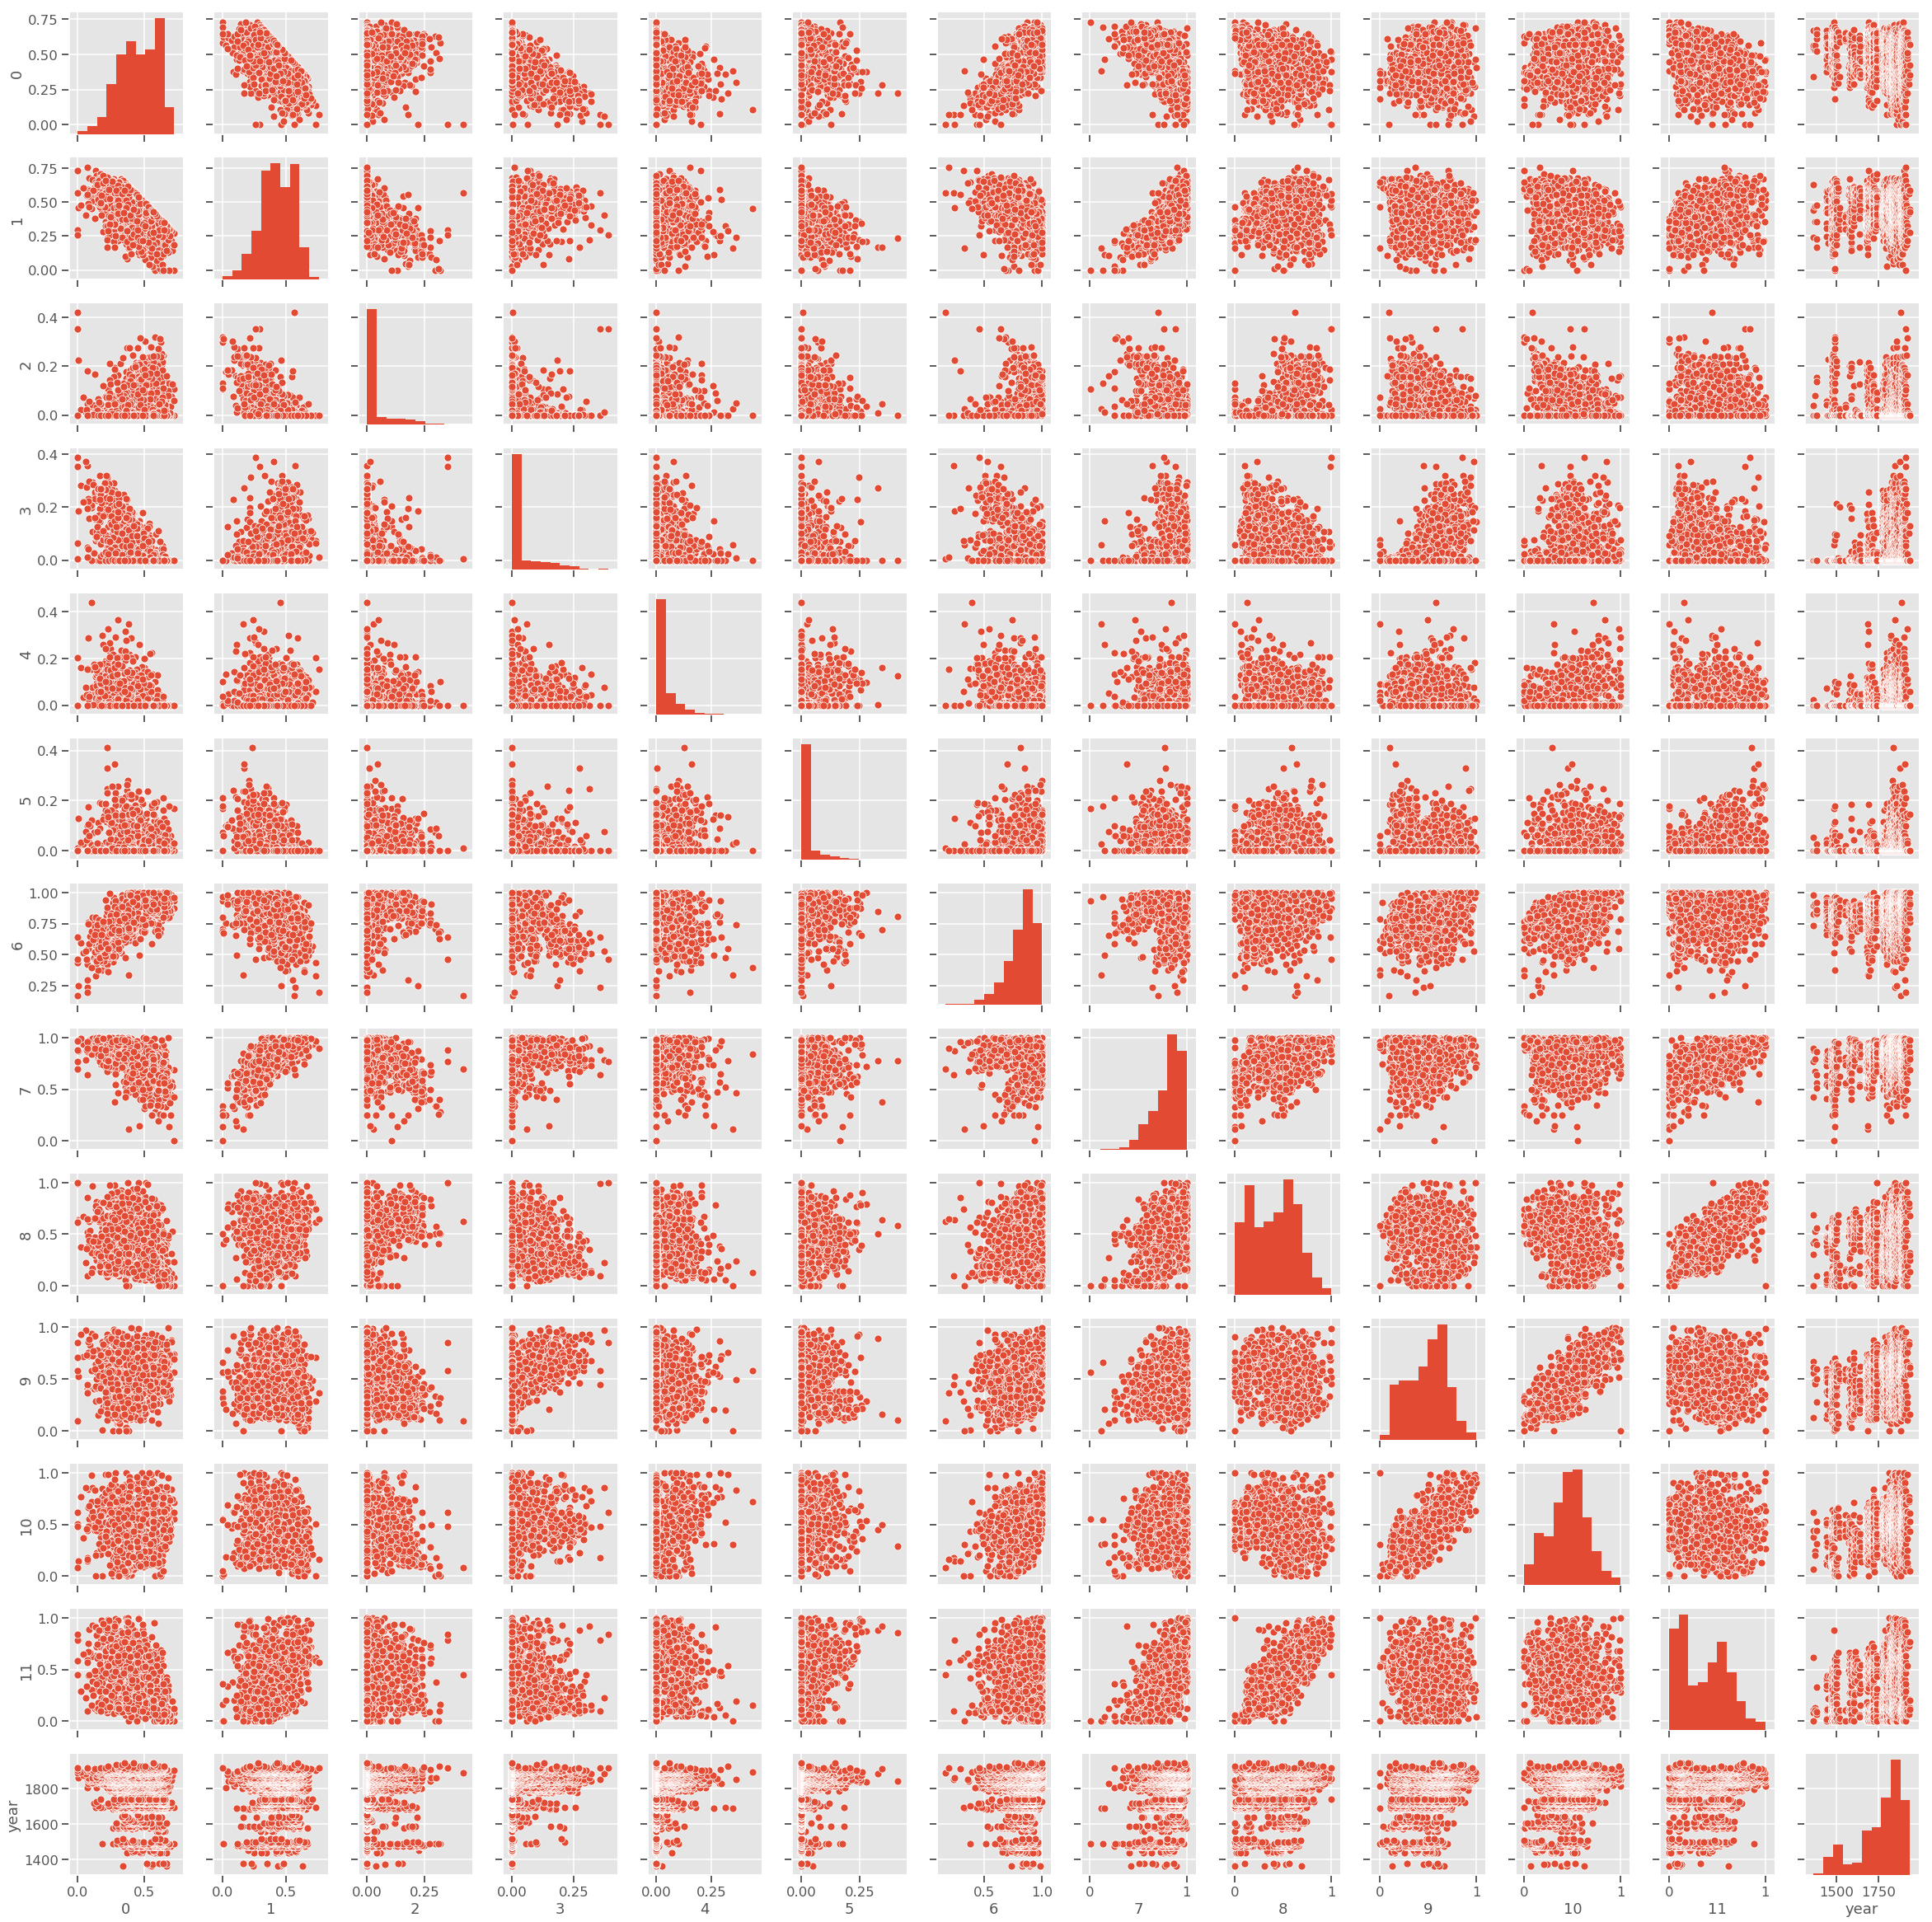

In [184]:
sns.pairplot(df[[str(i) for i in range(12)]+['year']])